In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import emoji
import datetime
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from os import path
from PIL import Image
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from unidecode import unidecode
import unicodedata

# Twitter Dataset

### Dataset Exploration

In [2]:
twitter = pd.read_excel("twitter.xlsx")
twitter.head()

,title,content,from,locatiion,date,images,url,by,likes,shares
0,NaN,Kalvin Phillips hopeful of World Cup inclusion...,myKhel.com,Bengaluru,2022-11-08 10:40:56,[],https://twitter.com/mykhelcom/status/158981016...,myKhel.com,0,0
1,NaN,Qatar promises a 'carbon-neutral' FIFA World C...,Republic,"Mumbai, India",2022-11-08 10:58:55,[],https://twitter.com/republic/status/1589814697...,Republic,10,1
2,NaN,Qatar's promise of 'carbon-neutral' World Cup ...,Carbon Credit Research,Worldwide,2022-11-08 11:08:09,[],https://twitter.com/CarbonCreditRes/status/158...,Carbon Credit Research,0,0
3,NaN,"Around 6,000 Argentine Fans Banned from Stadiu...",Viral Cyprus,Worldwide,2022-11-08 12:00:50,[],https://twitter.com/viralposthq/status/1589830...,Viral Cyprus,0,0
4,NaN,Happy World Cup Final Day!. Argentina to win 2...,MrX_NFT,NaN,2022-12-18 16:21:57,[],https://twitter.com/MrX__NFT/status/1604391505...,MrX_NFT,0,0


In [3]:
twitter.isna().sum()

title        27508
content          0
from             2
locatiion     8365
date             0
images           0
url              0
by               2
likes            0
shares           0
dtype: int64

In [4]:
twitter.duplicated().sum()

0

In [5]:
twitter['content'].duplicated().sum()

159

In [6]:
twitter = twitter.drop_duplicates(subset='content', keep=False)

In [7]:
twitter = twitter.drop(columns=["title", "images", "url", "by", "locatiion"]) #Erasing columns

new_column_names = {
    "from": "Publisher",
    "date": "Date",
    "likes": "Likes",
    "shares": "Shares"
}
twitter = twitter.rename(columns=new_column_names)

In [8]:
twitter['Date'] = twitter['Date'].dt.date #Convert to ymd

twitter.head()

,content,Publisher,Date,Likes,Shares
0,Kalvin Phillips hopeful of World Cup inclusion...,myKhel.com,2022-11-08,0,0
1,Qatar promises a 'carbon-neutral' FIFA World C...,Republic,2022-11-08,10,1
2,Qatar's promise of 'carbon-neutral' World Cup ...,Carbon Credit Research,2022-11-08,0,0
3,"Around 6,000 Argentine Fans Banned from Stadiu...",Viral Cyprus,2022-11-08,0,0
4,Happy World Cup Final Day!. Argentina to win 2...,MrX_NFT,2022-12-18,0,0


In [9]:
twitter.dtypes

content      object
Publisher    object
Date         object
Likes         int64
Shares        int64
dtype: object

In [10]:
twitter = twitter.sort_values(by=["Date"])

twitter.head()

,content,Publisher,Date,Likes,Shares
18924,Paul Pogba will miss the Qatar 2022 World Cup ...,World Cup 2022,2022-11-01,12,1
2774,Qatar is facing renewed pressure on migrant wo...,Colossus Diplomacy,2022-11-01,0,0
2775,@PUTERA_Miguel Daniel! How are you? I need y...,Blackburn Roverseasson ��,2022-11-01,0,0
2776,England boss Gareth Southgate says Qatar worke...,SPORTS CIRCUS INT.,2022-11-01,0,0
2777,Mikel Arteta on Thomas Partey: “We have been w...,King David,2022-11-01,0,0


### Data Analysis

In [11]:
twitter.describe()

,Likes,Shares
count,27256.000000,27256.000000
mean,187.320590,39.446947
std,4962.303879,1535.579967
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,3.000000,1.000000
max,629808.000000,236759.000000


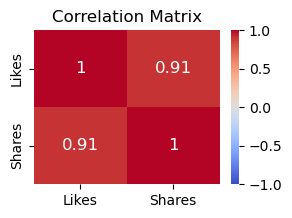

In [12]:
correlation_matrix = twitter.corr()

plt.figure(figsize=(3, 2))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 12})
plt.title("Correlation Matrix")
plt.show()

In [13]:
#Likes distribution

likes_percentiles = twitter["Likes"].describe(percentiles=[.50, .60, .70, .75, .80, .85, .90, .95, .96, .97, .98, .99, .995, .999])
print(likes_percentiles)

count     27256.000000
mean        187.320590
std        4962.303879
min           0.000000
50%           0.000000
60%           1.000000
70%           2.000000
75%           3.000000
80%           5.000000
85%          10.000000
90%          23.000000
95%          75.000000
96%         110.000000
97%         175.000000
98%         346.900000
99%        1289.450000
99.5%      4120.500000
99.9%     43300.605000
max      629808.000000
Name: Likes, dtype: float64


In [14]:
boundaries = [0, 1, 11, 101, 1001, 10001, float('inf')]
labels = ['0', '1-10', '11-100', '101-1000', '1001-10000', '10000+']

like_counts = pd.cut(twitter['Likes'], bins=boundaries, labels=labels, right=False)
like_counts = like_counts.value_counts().reset_index()
like_counts.columns = ['Likes', 'Number of Entries']
like_counts = like_counts.sort_values(by='Likes')

like_counts

,Likes,Number of Entries
0,0,15800
1,1-10,7470
2,11-100,2846
3,101-1000,832
4,1001-10000,228
5,10000+,80


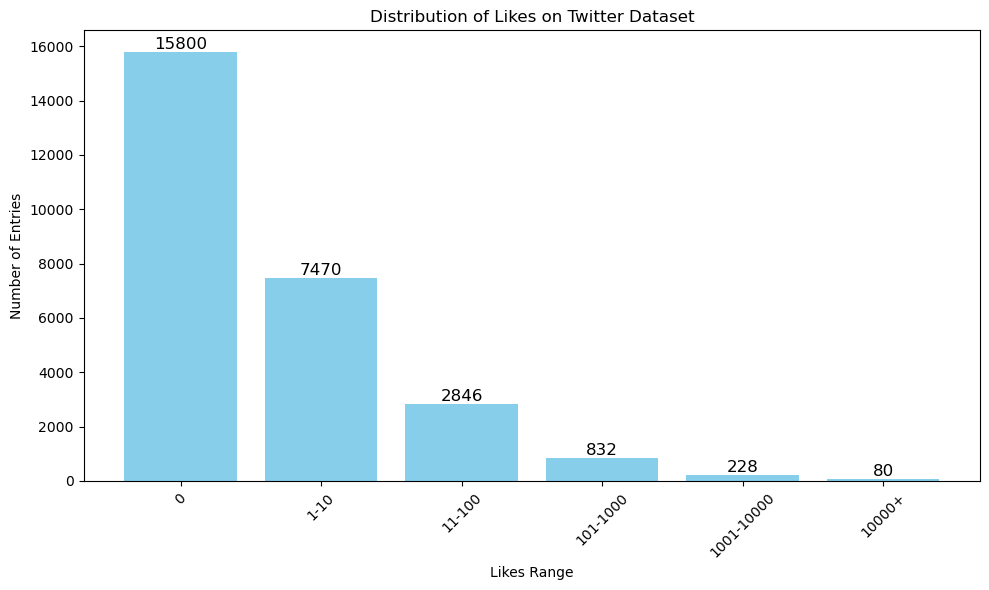

In [15]:
likes = like_counts['Likes']
entry_counts = like_counts['Number of Entries']

plt.figure(figsize=(10, 6))
bars = plt.bar(likes, entry_counts, color='skyblue')

plt.xlabel('Likes Range')
plt.ylabel('Number of Entries')
plt.title('Distribution of Likes on Twitter Dataset')

for bar, count in zip(bars, entry_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
twitter_sort_likes = twitter.sort_values(by=['Likes'], ascending=False)

second_row_text = twitter_sort_likes.iloc[1]['content']
third_row_text = twitter_sort_likes.iloc[2]['content']

print("Text from the second row:\n", second_row_text)
print("\nText from the third row:\n", third_row_text)

Text from the second row:
 It’s the end for Cristiano Ronaldo at the World Cup. The Portuguese leaves the pitch in tears on his last appearance ever in the World Cup. ��� #Ronaldo #Qatar2022 https://t.co/fWLC6YN0Wj

Text from the third row:
 Lionel Messi: “No, I’m NOT gonna retire from the national team. I want to keep playing as World Cup champions with Argentina shirt”, tells TyC Sports. ⭐️�� #Qatar2022 https://t.co/Nd9KGboZgG


In [17]:
#Shares distribution

shares_percentiles = twitter["Shares"].describe(percentiles=[.50, .75, .85, .90, .95, .96, .97, .98, .99, .995, .999])
print(shares_percentiles)

count     27256.000000
mean         39.446947
std        1535.579967
min           0.000000
50%           0.000000
75%           1.000000
85%           3.000000
90%           7.000000
95%          22.000000
96%          31.000000
97%          48.000000
98%          85.000000
99%         366.000000
99.5%      1106.300000
99.9%      7033.615000
max      236759.000000
Name: Shares, dtype: float64


In [18]:
publisher_counts = twitter['Publisher'].value_counts()

publisher_counts.head(200)

Gulf-Times              342
The Voice of America    121
beIN SPORTS             101
#YFM                     89
Metro                    83
                       ... 
Lucy Goldstraw           11
The Express Tribune      10
TheJournal.ie            10
Ooredoo Maldives         10
Bloomberg Politics       10
Name: Publisher, Length: 200, dtype: int64

In [19]:
publisher_avg_likes = twitter.groupby('Publisher')['Likes'].mean()
avg_likes_sorted = publisher_avg_likes.sort_values(ascending=False)

avg_likes_sorted

Publisher
BTS_official                 629808.0
Achraf Hakimi                 92355.0
Daily Loud                    84232.0
Piers Morgan                  67218.5
tito’s rich uncle             63098.0
                               ...   
LARRY LE,Pharmacist MBA           0.0
LB Press-Telegram                 0.0
LCFC Cozzy �� #RodgersOut         0.0
LDNsFinest                        0.0
Misturat Abdulrasaq               0.0
Name: Likes, Length: 17702, dtype: float64

In [20]:
publisher_total_likes = twitter.groupby('Publisher')['Likes'].sum()
total_likes_sorted = publisher_total_likes.sort_values(ascending=False)

total_likes_sorted

Publisher
Fabrizio Romano              1003027
BTS_official                  629808
ESPN FC                       315185
Football Tweet ⚽             214856
Piers Morgan                  134437
                              ...   
LARRY LE,Pharmacist MBA            0
LB Press-Telegram                  0
LCFC Cozzy �� #RodgersOut          0
LDNsFinest                         0
Misturat Abdulrasaq                0
Name: Likes, Length: 17702, dtype: int64

In [21]:
date_counts = twitter['Date'].value_counts()

date_counts

2022-11-21    2782
2022-11-20    1902
2022-11-19    1318
2022-11-18    1077
2022-11-22     990
              ... 
2023-01-04       4
2023-01-08       3
2023-01-09       3
2023-01-07       2
2023-01-06       1
Name: Date, Length: 92, dtype: int64

In [22]:
twitter_sort_likes = twitter.sort_values(by=['Likes'], ascending=False)

twitter_sort_likes.head()

,content,Publisher,Date,Likes,Shares
11760,방탄소년단 ‘정국’이 2022 FIFA 카타르 월드컵 공식 사운드트랙과 월드컵 개막...,BTS_official,2022-11-12,629808,236759
21390,It’s the end for Cristiano Ronaldo at the Worl...,Fabrizio Romano,2022-12-11,231247,27972
25127,"Lionel Messi: “No, I’m NOT gonna retire from t...",Fabrizio Romano,2022-12-19,184694,16489
11710,"�️ Abdullah Al Nasari, Head of Security at the...",Football Tweet ⚽,2022-11-12,149618,27087
10593,Outrageously disrespectful to Qatar that the B...,Piers Morgan,2022-11-21,133871,21023


In [23]:
twitter_sort_shares = twitter.sort_values(by=['Shares'], ascending=False)

twitter_sort_shares.head()

,content,Publisher,Date,Likes,Shares
11760,방탄소년단 ‘정국’이 2022 FIFA 카타르 월드컵 공식 사운드트랙과 월드컵 개막...,BTS_official,2022-11-12,629808,236759
10585,Jungkook of BTS and Qatari singer Fahad Al Kub...,The Peninsula Qatar,2022-11-20,127116,53379
21390,It’s the end for Cristiano Ronaldo at the Worl...,Fabrizio Romano,2022-12-11,231247,27972
11710,"�️ Abdullah Al Nasari, Head of Security at the...",Football Tweet ⚽,2022-11-12,149618,27087
10593,Outrageously disrespectful to Qatar that the B...,Piers Morgan,2022-11-21,133871,21023


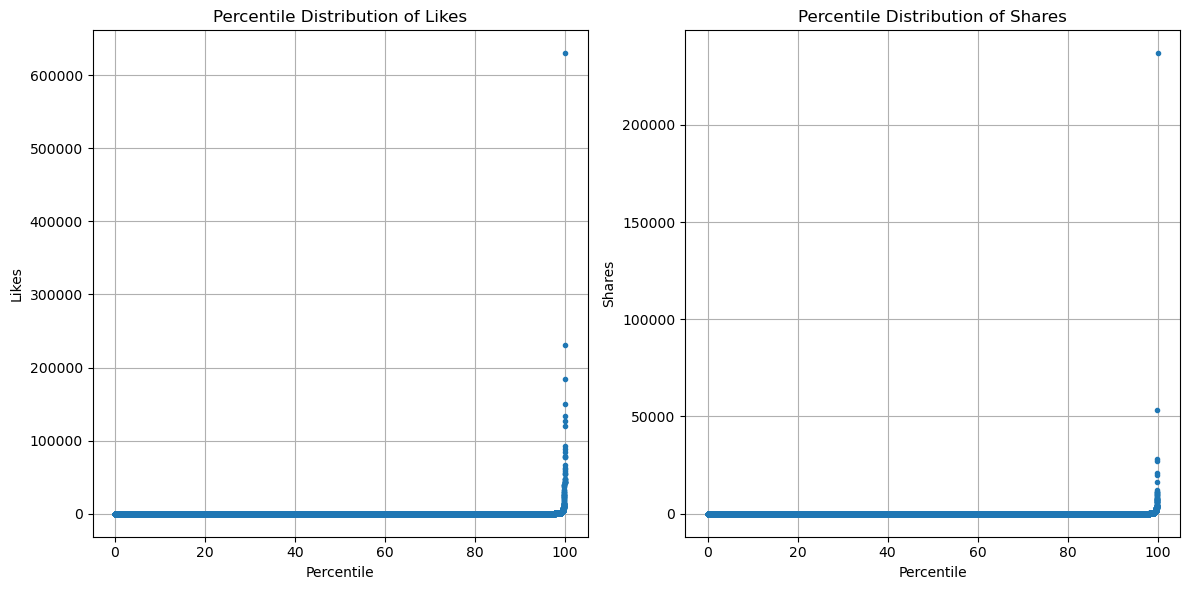

In [24]:
likes_data = twitter["Likes"]
shares_data = twitter["Shares"]

likes_data_sorted = likes_data.sort_values()
shares_data_sorted = shares_data.sort_values()

n = len(likes_data_sorted)
cumulative_distribution_likes = np.arange(1, n + 1) / n
cumulative_distribution_shares = np.arange(1, n + 1) / n

likes_adjusted = cumulative_distribution_likes * 100
shares_adjusted = cumulative_distribution_shares * 100

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(likes_adjusted, likes_data_sorted, marker='.', linestyle='none')
plt.title("Percentile Distribution of Likes")
plt.xlabel("Percentile")
plt.ylabel("Likes")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(shares_adjusted, shares_data_sorted, marker='.', linestyle='none')
plt.title("Percentile Distribution of Shares")
plt.xlabel("Percentile")
plt.ylabel("Shares")
plt.grid(True)

plt.tight_layout()
plt.show()

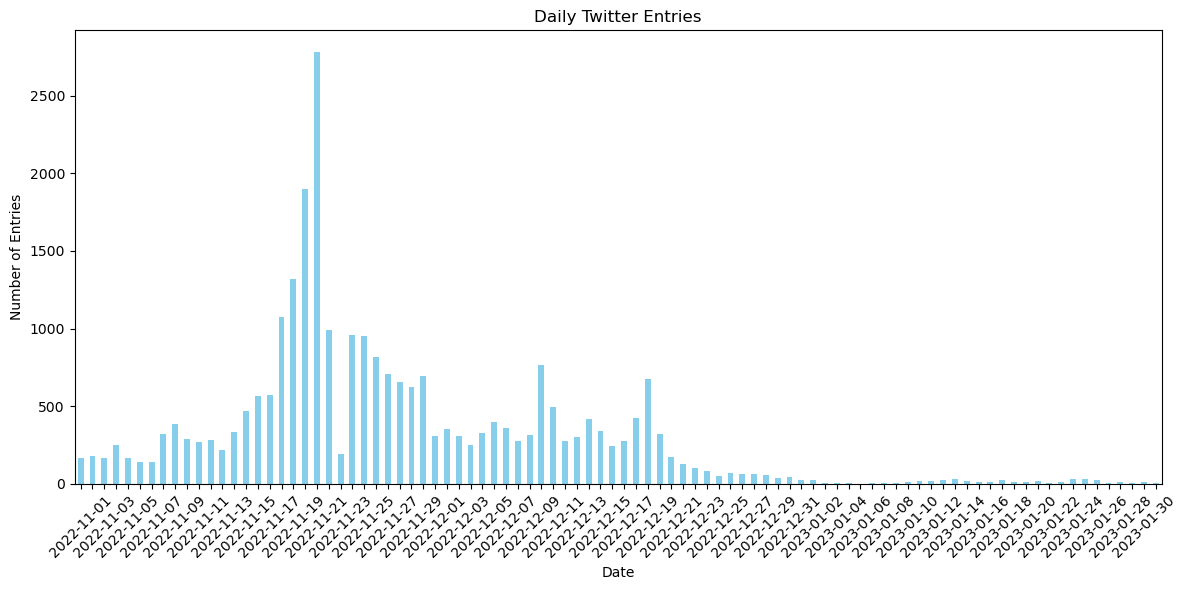

In [25]:
daily_entry_counts = twitter.groupby(twitter["Date"]).size()

plt.figure(figsize=(12, 6))
daily_entry_counts.plot(kind="bar", color="skyblue")
plt.title("Daily Twitter Entries")
plt.xlabel("Date")
plt.ylabel("Number of Entries")
plt.xticks(rotation=45)

x_labels = plt.gca().get_xticklabels()
for i, label in enumerate(x_labels):
    if i % 2 != 0:
        label.set_visible(False)
plt.tight_layout()
plt.show()

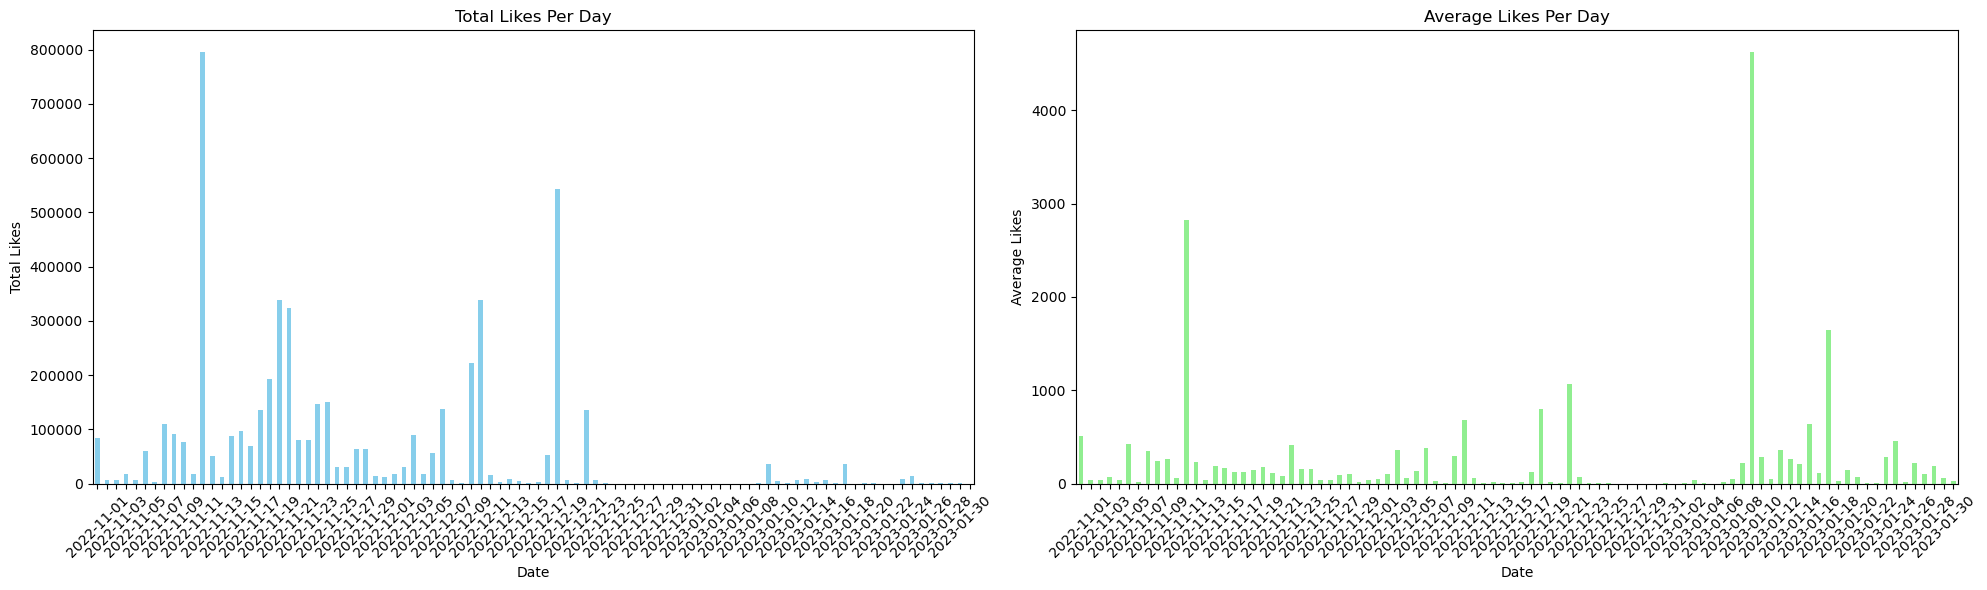

In [26]:
total_likes_per_day = twitter.groupby(twitter["Date"])["Likes"].sum()
average_likes_per_day = twitter.groupby(twitter["Date"])["Likes"].mean()

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

total_likes_per_day.plot(kind="bar", color="skyblue")
plt.title("Total Likes Per Day")
plt.xlabel("Date")
plt.ylabel("Total Likes")
plt.xticks(rotation=45)

x_labels_total = plt.gca().get_xticklabels()
for i, label in enumerate(x_labels_total):
    if i % 2 != 0:
        label.set_visible(False)

plt.subplot(1, 2, 2)

average_likes_per_day.plot(kind="bar", color="lightgreen")
plt.title("Average Likes Per Day")
plt.xlabel("Date")
plt.ylabel("Average Likes")
plt.xticks(rotation=45)

x_labels_average = plt.gca().get_xticklabels()
for i, label in enumerate(x_labels_average):
    if i % 2 != 0:
        label.set_visible(False)

plt.tight_layout()
plt.show()

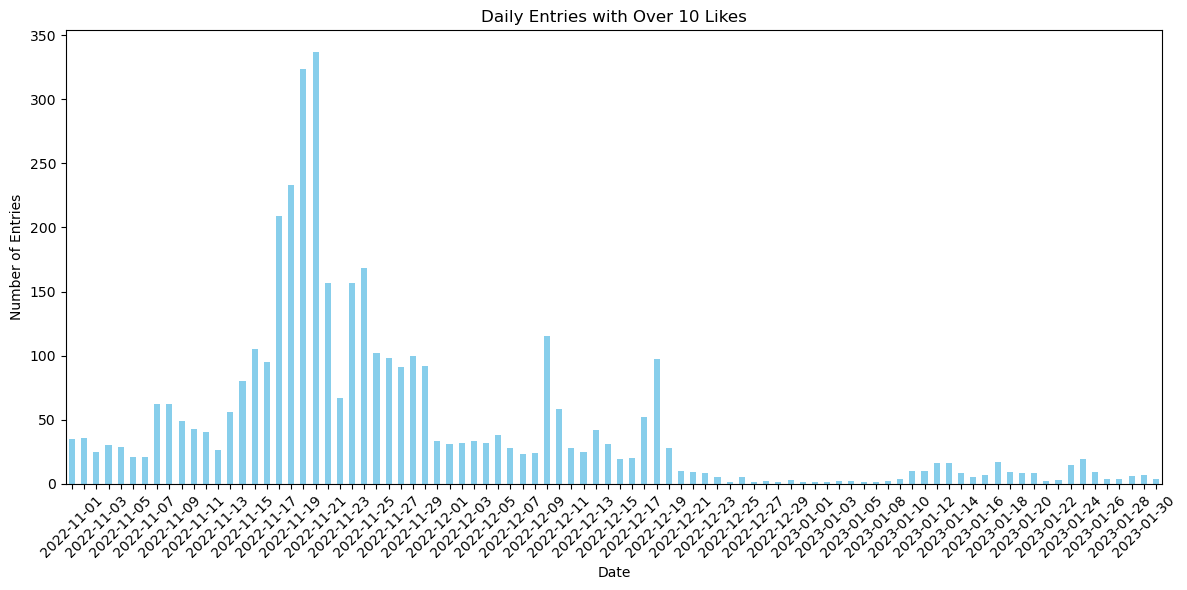

In [27]:
twitter['Date'] = pd.to_datetime(twitter['Date'])
filtered_twitter = twitter[twitter['Likes'] > 10]

entries_over_10_likes_per_day = filtered_twitter.groupby("Date")["Likes"].count()

plt.figure(figsize=(12, 6))

date_labels = entries_over_10_likes_per_day.index.strftime('%Y-%m-%d')

entries_over_10_likes_per_day.plot(kind="bar", color="skyblue")
plt.title("Daily Entries with Over 10 Likes")
plt.xlabel("Date")
plt.ylabel("Number of Entries")
plt.xticks(range(len(date_labels)), date_labels, rotation=45)

x_labels_entries = plt.gca().get_xticklabels()
for i, label in enumerate(x_labels_entries):
    if i % 2 != 0:
        label.set_visible(False)

plt.tight_layout()
plt.show()

/Users/farrelw/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/farrelw/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 59904 (\uea00) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


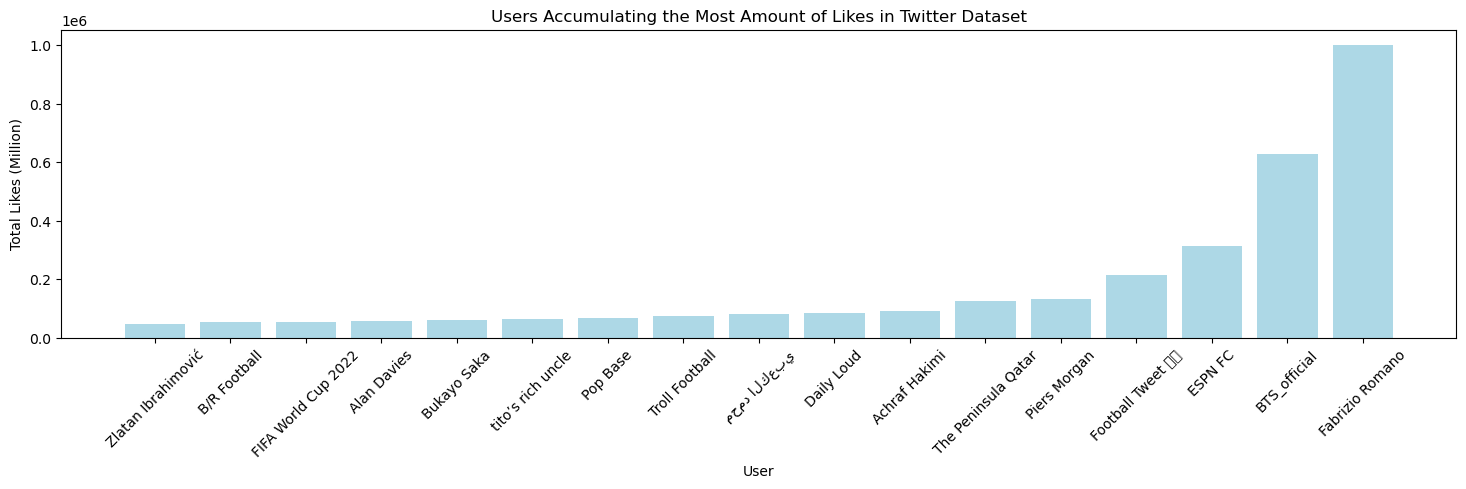

In [28]:
user_likes = twitter.groupby(["Publisher"])["Likes"].sum()
filtered_user_likes = user_likes[user_likes >= 47000]
filtered_user_likes = filtered_user_likes.sort_values()

fig, ax = plt.subplots(figsize=(18, 4))
plt.bar(filtered_user_likes.index, filtered_user_likes.values, color = 'lightblue')

plt.xlabel('User')
plt.ylabel('Total Likes (Million)')
plt.title('Users Accumulating the Most Amount of Likes in Twitter Dataset')
plt.xticks(rotation=45)

plt.show()

/Users/farrelw/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/farrelw/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/farrelw/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 59904 (\uea00) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


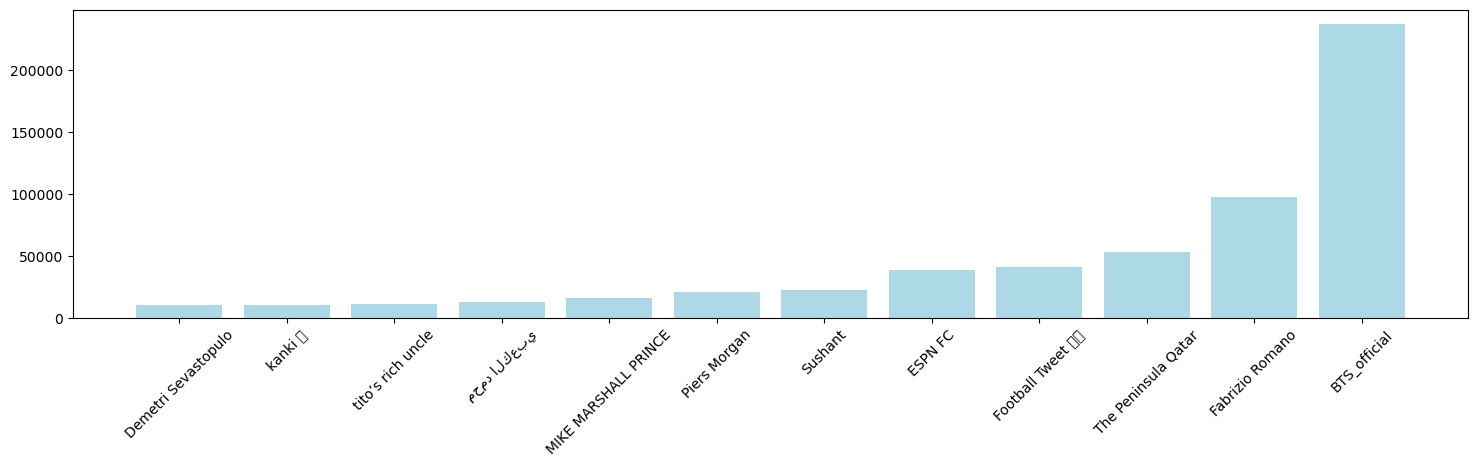

In [29]:
user_com = twitter.groupby("Publisher")["Shares"].sum()
filtered_user_com = user_com[user_com >= 10000]
filtered_user_com = filtered_user_com.sort_values()

fig, ax = plt.subplots(figsize=(18, 4))
plt.bar(filtered_user_com.index, filtered_user_com.values, color = 'lightblue')
plt.xticks(rotation=45)
plt.show()

### NTLK Package

In [30]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

twitter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/farrelw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/farrelw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/farrelw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,content,Publisher,Date,Likes,Shares
18924,Paul Pogba will miss the Qatar 2022 World Cup ...,World Cup 2022,2022-11-01,12,1
2774,Qatar is facing renewed pressure on migrant wo...,Colossus Diplomacy,2022-11-01,0,0
2775,@PUTERA_Miguel Daniel! How are you? I need y...,Blackburn Roverseasson ��,2022-11-01,0,0
2776,England boss Gareth Southgate says Qatar worke...,SPORTS CIRCUS INT.,2022-11-01,0,0
2777,Mikel Arteta on Thomas Partey: “We have been w...,King David,2022-11-01,0,0
...,...,...,...,...,...
9677,“Dreamers [Music from the FIFA World Cup Qatar...,Jungkook Charts,2023-01-31,75,21
9662,From 700 million years ago to the World Cup: I...,Breaking News,2023-01-31,0,0
9679,Please @Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10
9661,Lionel Messi has spoken at length following hi...,Mirror Football,2023-01-31,18,4


In [31]:
def extract_hashtags(text):
    hashtags = [tag for tag in text.split() if tag.startswith('#')]
    return ' '.join([word for word in text.split() if not word.startswith('#')]), ' '.join(hashtags)

def merge_hashtags(text):
    return re.sub(r'#\s', '#', text)

twitter['content'] = twitter['content'].apply(merge_hashtags)
twitter[['content', 'Hashtag']] = twitter['content'].apply(extract_hashtags).apply(pd.Series)

twitter

,content,Publisher,Date,Likes,Shares,Hashtag
18924,Paul Pogba will miss the Qatar 2022 World Cup ...,World Cup 2022,2022-11-01,12,1,#Pogba
2774,Qatar is facing renewed pressure on migrant wo...,Colossus Diplomacy,2022-11-01,0,0,
2775,@PUTERA_Miguel Daniel! How are you? I need you...,Blackburn Roverseasson ��,2022-11-01,0,0,
2776,England boss Gareth Southgate says Qatar worke...,SPORTS CIRCUS INT.,2022-11-01,0,0,
2777,Mikel Arteta on Thomas Partey: “We have been w...,King David,2022-11-01,0,0,
...,...,...,...,...,...,...
9677,“Dreamers [Music from the FIFA World Cup Qatar...,Jungkook Charts,2023-01-31,75,21,#118.
9662,From 700 million years ago to the World Cup: I...,Breaking News,2023-01-31,0,0,
9679,Please @Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10,
9661,Lionel Messi has spoken at length following hi...,Mirror Football,2023-01-31,18,4,


In [32]:
#Eliminates stopwords

twitter['content'] = twitter['content'].apply(lambda text: ' '.join([word for word in word_tokenize(text) if word.lower() not in stop_words]))

twitter

,content,Publisher,Date,Likes,Shares,Hashtag
18924,Paul Pogba miss Qatar 2022 World Cup due new i...,World Cup 2022,2022-11-01,12,1,#Pogba
2774,Qatar facing renewed pressure migrant worker L...,Colossus Diplomacy,2022-11-01,0,0,
2775,@ PUTERA_Miguel Daniel ! ? need help . working...,Blackburn Roverseasson ��,2022-11-01,0,0,
2776,England boss Gareth Southgate says Qatar worke...,SPORTS CIRCUS INT.,2022-11-01,0,0,
2777,Mikel Arteta Thomas Partey : “ waiting ! happe...,King David,2022-11-01,0,0,
...,...,...,...,...,...,...
9677,“ Dreamers [ Music FIFA World Cup Qatar 2022 O...,Jungkook Charts,2023-01-31,75,21,#118.
9662,700 million years ago World Cup : Inside Qatar...,Breaking News,2023-01-31,0,0,
9679,Please @ Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10,
9661,Lionel Messi spoken length following historic ...,Mirror Football,2023-01-31,18,4,


In [33]:
#Remove emojis

def remove_emojis(twitter):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        u"\u0600-\u06FF"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',twitter)

twitter['content'] = twitter['content'].apply(remove_emojis)
twitter['Hashtag'] = twitter['Hashtag'].apply(remove_emojis)

twitter

,content,Publisher,Date,Likes,Shares,Hashtag
18924,Paul Pogba miss Qatar 2022 World Cup due new i...,World Cup 2022,2022-11-01,12,1,#Pogba
2774,Qatar facing renewed pressure migrant worker L...,Colossus Diplomacy,2022-11-01,0,0,
2775,@ PUTERA_Miguel Daniel ! ? need help . working...,Blackburn Roverseasson ��,2022-11-01,0,0,
2776,England boss Gareth Southgate says Qatar worke...,SPORTS CIRCUS INT.,2022-11-01,0,0,
2777,Mikel Arteta Thomas Partey : “ waiting ! happe...,King David,2022-11-01,0,0,
...,...,...,...,...,...,...
9677,“ Dreamers [ Music FIFA World Cup Qatar 2022 O...,Jungkook Charts,2023-01-31,75,21,#118.
9662,700 million years ago World Cup : Inside Qatar...,Breaking News,2023-01-31,0,0,
9679,Please @ Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10,
9661,Lionel Messi spoken length following historic ...,Mirror Football,2023-01-31,18,4,


In [34]:
#Lemmatization

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Assuming verbs
    return ' '.join(lemmatized_words)

twitter['content'] = twitter['content'].apply(lemmatize_text)
twitter['Hashtag'] = twitter['Hashtag'].apply(lemmatize_text)

twitter

,content,Publisher,Date,Likes,Shares,Hashtag
18924,Paul Pogba miss Qatar 2022 World Cup due new i...,World Cup 2022,2022-11-01,12,1,# Pogba
2774,Qatar face renew pressure migrant worker LGBT ...,Colossus Diplomacy,2022-11-01,0,0,
2775,@ PUTERA_Miguel Daniel ! ? need help . work am...,Blackburn Roverseasson ��,2022-11-01,0,0,
2776,England boss Gareth Southgate say Qatar worker...,SPORTS CIRCUS INT.,2022-11-01,0,0,
2777,"Mikel Arteta Thomas Partey : “ wait ! happen ,...",King David,2022-11-01,0,0,
...,...,...,...,...,...,...
9677,“ Dreamers [ Music FIFA World Cup Qatar 2022 O...,Jungkook Charts,2023-01-31,75,21,# 118 .
9662,700 million years ago World Cup : Inside Qatar...,Breaking News,2023-01-31,0,0,
9679,Please @ Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10,
9661,Lionel Messi speak length follow historic Worl...,Mirror Football,2023-01-31,18,4,


In [35]:
#Remove punctuation marks

def remove_punctuation(text):
    return re.sub(r'[^\w\s#]', '', text)

twitter['content'] = twitter['content'].apply(remove_punctuation)
twitter

,content,Publisher,Date,Likes,Shares,Hashtag
18924,Paul Pogba miss Qatar 2022 World Cup due new i...,World Cup 2022,2022-11-01,12,1,# Pogba
2774,Qatar face renew pressure migrant worker LGBT ...,Colossus Diplomacy,2022-11-01,0,0,
2775,PUTERA_Miguel Daniel need help work ambiti...,Blackburn Roverseasson ��,2022-11-01,0,0,
2776,England boss Gareth Southgate say Qatar worker...,SPORTS CIRCUS INT.,2022-11-01,0,0,
2777,Mikel Arteta Thomas Partey wait happen hap...,King David,2022-11-01,0,0,
...,...,...,...,...,...,...
9677,Dreamers Music FIFA World Cup Qatar 2022 Off...,Jungkook Charts,2023-01-31,75,21,# 118 .
9662,700 million years ago World Cup Inside Qatar ...,Breaking News,2023-01-31,0,0,
9679,Please Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10,
9661,Lionel Messi speak length follow historic Worl...,Mirror Football,2023-01-31,18,4,


In [36]:
def remove_characters(text):
    characters_to_remove = ["``", "`", "'", "’", "“", "'s", "�"]
    for char in characters_to_remove:
        text = text.replace(char, '')
    return text

def remove_words(text):
    words_to_remove = ["FIFA", "fifa", "World", "world", "Cup", "cup", "2022", "FIFA Qatar", "Qatar FIFA", "Qatar World", "Qatar 2022"]
    for words in words_to_remove:
        text = text.replace(words, '')
    return text

def substitute_words(text):
    # Define word substitutions
    word_substitutions = {
        'fifa': 'FIFA',
        'world': 'World',
        'cup': 'Cup',
        'QatarFIFA': 'FIFAQatar'
    }
    for word, replacement in word_substitutions.items():
        text = text.replace(word, replacement)
    return text

def remove_standalone_s(text):
    return re.sub(r'\bs\b', ' ', text)

def remove_links(text):
    # Use regular expression to remove URLs
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

twitter['content'] = twitter['content'].apply(remove_characters)
twitter['content'] = twitter['content'].apply(remove_words)
twitter['content'] = twitter['content'].apply(remove_standalone_s)
twitter['content'] = twitter['content'].apply(remove_links)


twitter['content'] = twitter['content'].str.replace('FIFA World Cup', 'FIFAWorldCup')
twitter['content'] = twitter['content'].str.replace('World Cup', 'WorldCup')

twitter['Publisher'] = twitter['Publisher'].str.replace('�', '')
twitter['Hashtag'] = twitter['Hashtag'].apply(substitute_words)
twitter['Hashtag'] = twitter['Hashtag'].apply(remove_standalone_s)
twitter['Hashtag'] = twitter['Hashtag'].str.replace('�', '')

twitter = twitter[twitter['content'].apply(lambda tokens: 'RT' not in tokens)]

twitter

,content,Publisher,Date,Likes,Shares,Hashtag
18924,Paul Pogba miss Qatar due new injury confi...,World Cup 2022,2022-11-01,12,1,# Pogba
2774,Qatar face renew pressure migrant worker LGBT ...,Colossus Diplomacy,2022-11-01,0,0,
2775,PUTERA_Miguel Daniel need help work ambiti...,Blackburn Roverseasson,2022-11-01,0,0,
2776,England boss Gareth Southgate say Qatar worker...,SPORTS CIRCUS INT.,2022-11-01,0,0,
2777,Mikel Arteta Thomas Partey wait happen hap...,King David,2022-11-01,0,0,
...,...,...,...,...,...,...
9677,Dreamers Music Qatar Official Soundtrack...,Jungkook Charts,2023-01-31,75,21,# 118 .
9662,700 million years ago Inside Qatar best mu...,Breaking News,2023-01-31,0,0,
9679,Please Qatar bring back,Omar Aldhafiri,2023-01-31,46,10,
9661,Lionel Messi speak length follow historic su...,Mirror Football,2023-01-31,18,4,


In [37]:
twitter = twitter.sort_index()

### WordCloud

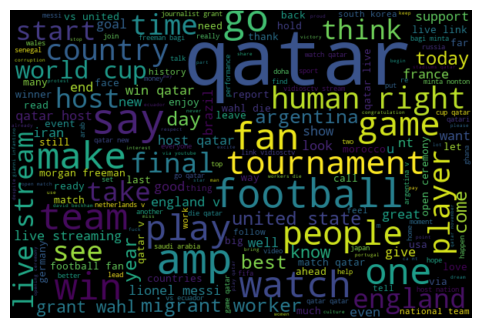

In [38]:
data = twitter['content']

text_data = ' '.join(data).lower()

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=1, 
                     max_font_size=100).generate(text_data)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

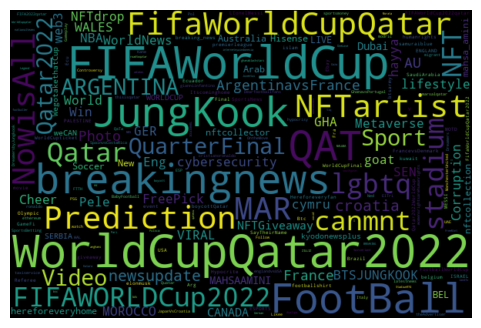

In [39]:
all_hashtags = ' '.join(twitter['Hashtag'])
unique_hashtags = set()

for hashtag in all_hashtags.split():
    unique_hashtags.add(hashtag)

unique_hashtags_list = list(unique_hashtags)
terms_to_exclude = ['t', 'https', 'co', 'al', 'MahsaAmini', 'ElonMusk', 'NFTCollection']

filtered_hashtags_list = [re.sub(r'\b(?:' + '|'.join(map(re.escape, terms_to_exclude)) + r')\b', '', hashtag) for hashtag in unique_hashtags_list]
filtered_hashtags_text = ' '.join(filtered_hashtags_list)

wordcloud = WordCloud(
    width=600,
    height=400,
    random_state=1,
    max_font_size=100
).generate(filtered_hashtags_text)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [40]:
twitter['Hashtag Y/N'] = twitter['Hashtag'].str.contains('#').apply(lambda x: 'Y' if x else 'N')

In [41]:
publisher_counts = twitter.groupby('Publisher')['Hashtag Y/N'].value_counts().unstack(fill_value=0)
publisher_counts = publisher_counts.reset_index()
publisher_counts.columns = ['Publisher', 'Hashtag_N', 'Hashtag_Y']

In [42]:
hashtag_df = publisher_counts[(publisher_counts['Hashtag_Y'] >= 3) & (publisher_counts['Hashtag_N'] >= 3)]

likes_grouped = twitter.groupby(['Publisher', 'Hashtag Y/N'])['Likes'].mean().unstack(fill_value=0)
likes_grouped.reset_index(inplace=True)

hashtag_df = hashtag_df.merge(likes_grouped, on='Publisher', how='left')
hashtag_df.rename(columns={'Y': 'Avg_Likes_Y', 'N': 'Avg_Likes_N'}, inplace=True)

hashtag_df.head()

,Publisher,Hashtag_N,Hashtag_Y,Avg_Likes_N,Avg_Likes_Y
0,,81,25,47.740741,2.960000
1,,16,19,1.125000,5.842105
2,,8,8,1040.375000,0.500000
3,.,20,5,385.050000,1.000000
4,10 News First,5,13,10.800000,62.923077


In [43]:
avg_likes_n = hashtag_df['Avg_Likes_N'].mean()
avg_likes_y = hashtag_df['Avg_Likes_Y'].mean()

### Player Analysis

In [44]:
player_df = pd.read_csv("player_stats.csv")

players = player_df[['player']]

In [45]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

players['player'] = players['player'].apply(remove_accents)

def extract_surname(full_name):
    names = full_name.split()
    return names[-1]

players['Name'] = players['player'].apply(extract_surname)

player_counts = {}
for player in players['Name']:
    count = twitter['content'].str.count(player).sum()
    player_counts[player] = count

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_7451/2162139403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['player'] = players['player'].apply(remove_accents)
/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_7451/2162139403.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['Name'] = players['player'].apply(extract_surname)


In [46]:
player_counts = pd.DataFrame.from_dict(player_counts, orient='index', columns=['Count'])
player_counts = player_counts.sort_values(by='Count', ascending=False)
player_counts

,Count
Messi,936
Ronaldo,358
David,241
Mbappe,179
Costa,132
...,...
Kaye,0
Pasalic,0
Chacon,0
Llorente,0


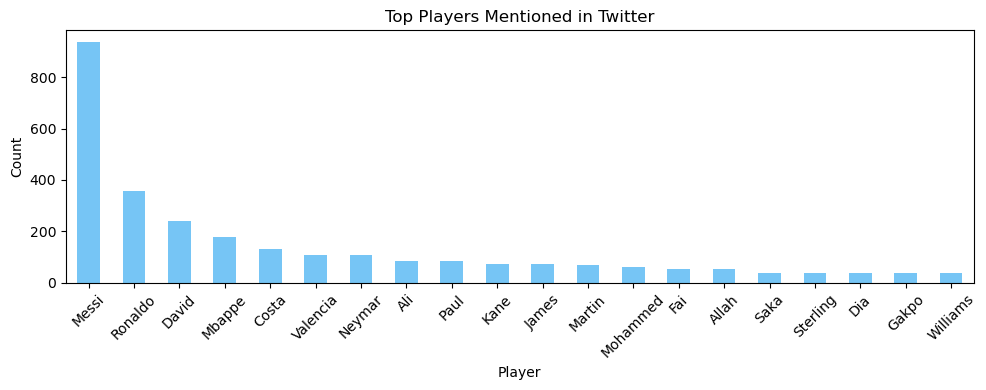

In [47]:
top_players = player_counts.head(20)

fig, ax = plt.subplots(figsize=(10, 4))
top_players.plot(kind='bar', ax=ax, legend=False, color = '#76c5f5')
ax.set_ylabel('Count')
ax.set_xlabel('Player')
ax.set_title('Top Players Mentioned in Twitter')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

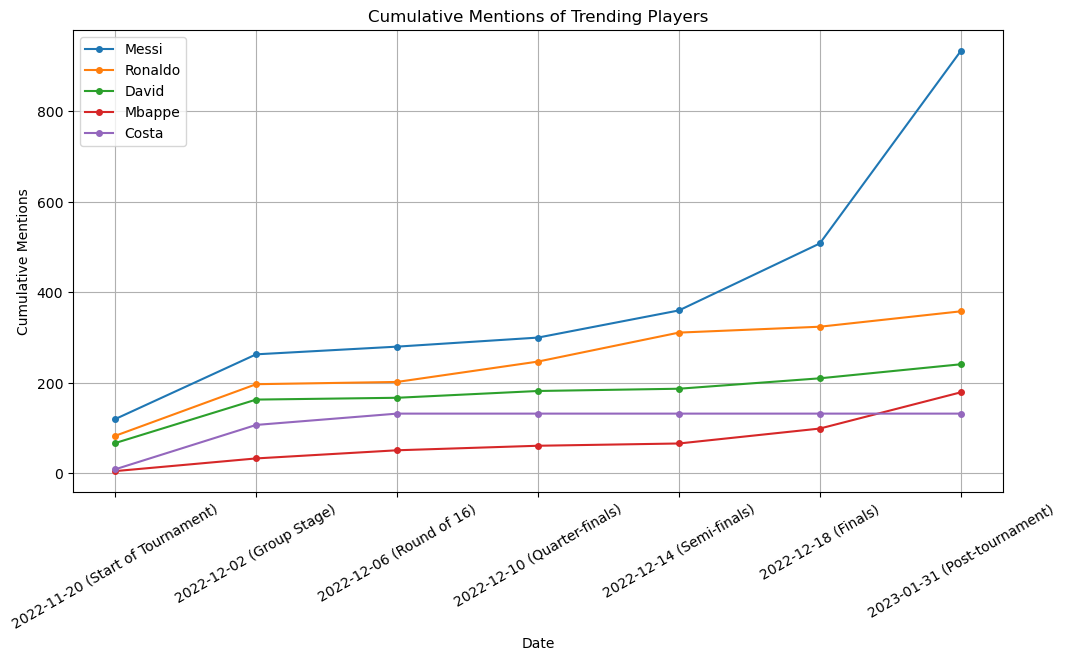

In [48]:
twitter['Date'] = pd.to_datetime(twitter['Date'])

checkpoint_dates = [
    pd.to_datetime('2022-11-20'),
    pd.to_datetime('2022-12-02'),
    pd.to_datetime('2022-12-06'),
    pd.to_datetime('2022-12-10'),
    pd.to_datetime('2022-12-14'),
    pd.to_datetime('2022-12-18'),
    pd.to_datetime('2023-01-31')
]

player_mentions = {}

for player in top_players.index:
    mentions_data = []

    for date in checkpoint_dates:
        mentions_before = twitter[twitter['Date'] < date]
        mentions_count = mentions_before['content'].str.count(player).sum()
        mentions_data.append(mentions_count)

    player_mentions[player] = mentions_data

mentions_df = pd.DataFrame.from_dict(player_mentions, orient='index', columns=[str(date) for date in checkpoint_dates])

fig, ax = plt.subplots(figsize=(12, 6))

top_players = mentions_df.loc[:, str(checkpoint_dates[-1])].sort_values(ascending=False).head(5)

for player in top_players.index:
    ax.plot(mentions_df.columns, mentions_df.loc[player], label=player, marker='o', markersize=4)

ax.set_ylabel('Cumulative Mentions')
ax.set_xlabel('Date')
ax.set_title('Cumulative Mentions of Trending Players')
ax.legend()

custom_labels = [
    '2022-11-20 (Start of Tournament)',
    '2022-12-02 (Group Stage)',
    '2022-12-06 (Round of 16)',
    '2022-12-10 (Quarter-finals)',
    '2022-12-14 (Semi-finals)',
    '2022-12-18 (Finals)',
    '2023-01-31 (Post-tournament)'
]

plt.xticks(mentions_df.columns, custom_labels, rotation=30)
plt.grid(True)

plt.show()

### Team Analysis

In [49]:
team_df = pd.read_csv("player_stats.csv")
team = team_df[['team']]

In [50]:
unique_teams = team['team'].unique()
unique_teams = [team.replace('IR Iran', 'Iran').replace('Korea Republic', 'Korea').replace('Saudi Arabia', 'Saudi').replace('Costa Rica', 'Costa').replace('United States', 'USA') for team in unique_teams]

In [51]:
team_mentions = {}

for team in unique_teams:
    mentions_count = twitter['content'].str.count(team).sum()
    team_mentions[team] = mentions_count

team_mentions_df = pd.DataFrame.from_dict(team_mentions, orient='index', columns=['Mentions'])
team_mentions_df = team_mentions_df.sort_values(by='Mentions', ascending=False)

team_mentions_df

,Mentions
Qatar,23681
England,1485
Argentina,1441
France,1024
Morocco,866
Ecuador,838
Iran,827
Brazil,726
Croatia,563
Netherlands,546


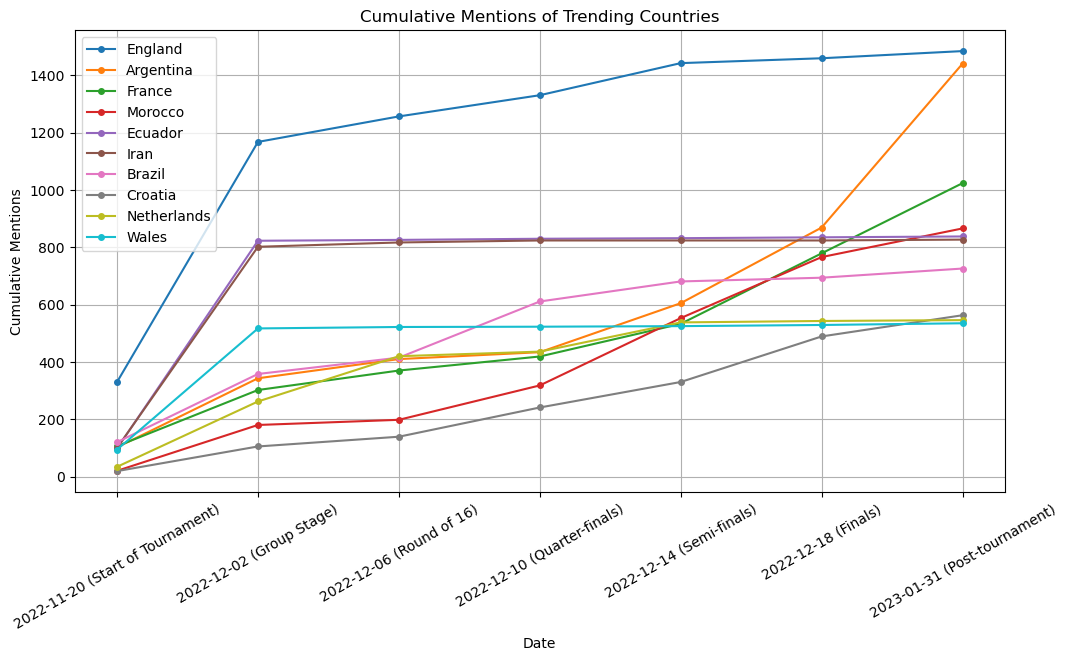

In [55]:
twitter['Date'] = pd.to_datetime(twitter['Date'])

checkpoint_dates = [
    pd.to_datetime('2022-11-20'),  # Tournament Start
    pd.to_datetime('2022-12-02'),  # Group Stage
    pd.to_datetime('2022-12-06'),  # Round of 16
    pd.to_datetime('2022-12-10'),  # Quarter Finals
    pd.to_datetime('2022-12-14'),  # Semi Finals
    pd.to_datetime('2022-12-18'),  # Finals
    pd.to_datetime('2023-01-31')   # Total
]


team_mentions = {}

for team in unique_teams:
    if team not in ['Qatar']:
        mentions_data = []
    
        for i, date in enumerate(checkpoint_dates):
            mentions_before = twitter[twitter['Date'] < date]
            mentions_count = mentions_before['content'].str.count(team).sum()
            mentions_data.append(mentions_count)

        team_mentions[team] = mentions_data

team_mentions_df = pd.DataFrame.from_dict(team_mentions, orient='index', columns=[str(date) for date in checkpoint_dates])
top_teams = team_mentions_df.loc[:, str(checkpoint_dates[-1])].sort_values(ascending=False).index[:10]

fig, ax = plt.subplots(figsize=(12, 6))

for team in top_teams:
    mentions = team_mentions_df.loc[team]
    ax.plot(mentions.index, mentions, label=team, marker='o', markersize=4)

ax.set_ylabel('Cumulative Mentions')
ax.set_xlabel('Date')
ax.set_title('Cumulative Mentions of Trending Countries')
ax.legend(labels, loc='upper left')

custom_labels = [
    '2022-11-20 (Start of Tournament)',
    '2022-12-02 (Group Stage)',
    '2022-12-06 (Round of 16)',
    '2022-12-10 (Quarter-finals)',
    '2022-12-14 (Semi-finals)',
    '2022-12-18 (Finals)',
    '2023-01-31 (Post-tournament)'
]

plt.xticks([str(date) for date in checkpoint_dates], custom_labels, rotation=30)
plt.grid(True)

plt.show()

In [56]:
twitter['Date'] = pd.to_datetime(twitter['Date'])

pre_tournament = twitter[twitter['Date'] < '2022-11-20']
tournament = twitter[(twitter['Date'] >= '2022-11-20') & (twitter['Date'] <= '2022-12-18')]
post_tournament = twitter[twitter['Date'] > '2022-12-18']

pre_tournament = pd.DataFrame(pre_tournament)
tournament = pd.DataFrame(tournament)
post_tournament = pd.DataFrame(post_tournament)

### Pre-Tournament

In [57]:
team_counts = {team: 0 for team in unique_teams}

for team in unique_teams:
    team_counts[team] = pre_tournament['content'].str.count(team.lower()).sum()

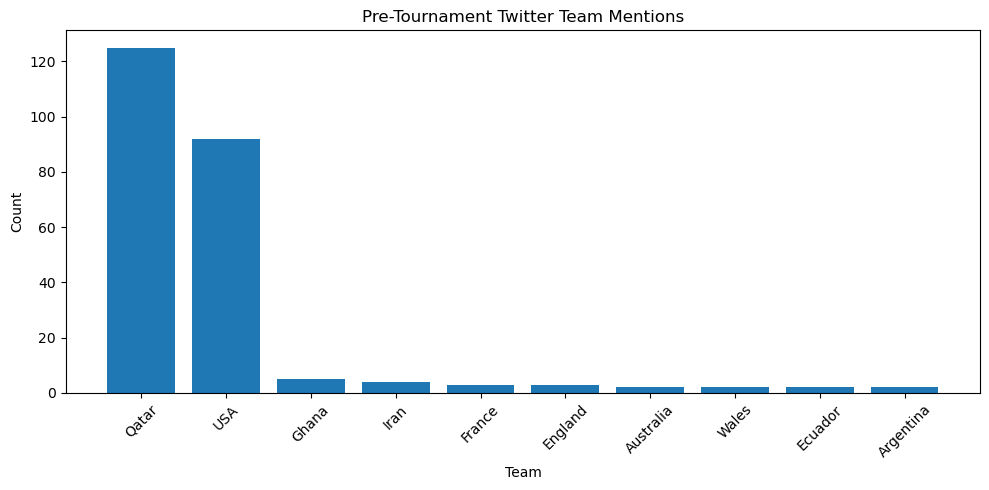

In [58]:
sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[0:10]
top_10_counts = list(sorted_team_counts.values())[0:10]

plt.figure(figsize=(10, 5))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Pre-Tournament Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Tournament

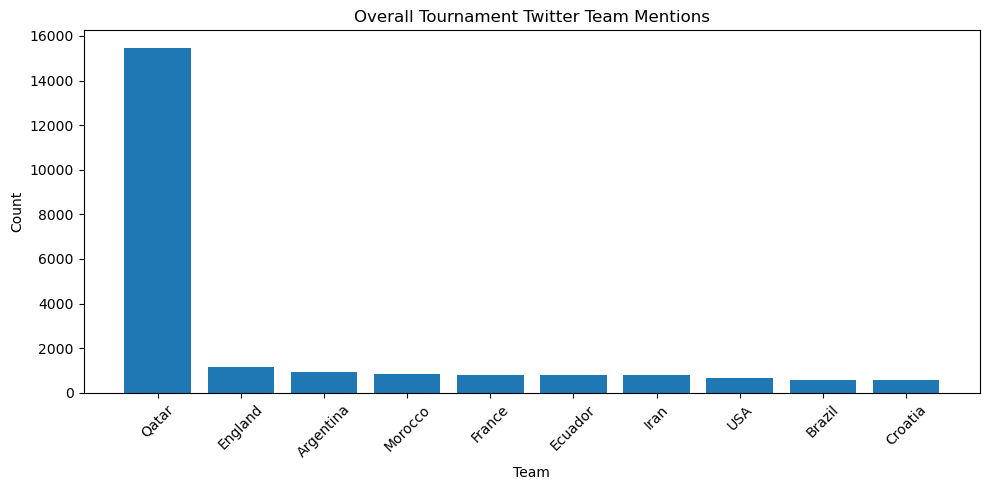

In [59]:
start_date = '2022-11-20'
end_date = '2022-12-18'

filtered_tournament = tournament[(tournament['Date'] >= start_date) & (tournament['Date'] <= end_date)]

team_counts = {team: 0 for team in unique_teams}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in unique_teams:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[:10]
top_10_counts = list(sorted_team_counts.values())[:10]

plt.figure(figsize=(10, 5))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Overall Tournament Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_7451/496089023.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tournament['content'] = filtered_tournament['content'].str.lower()


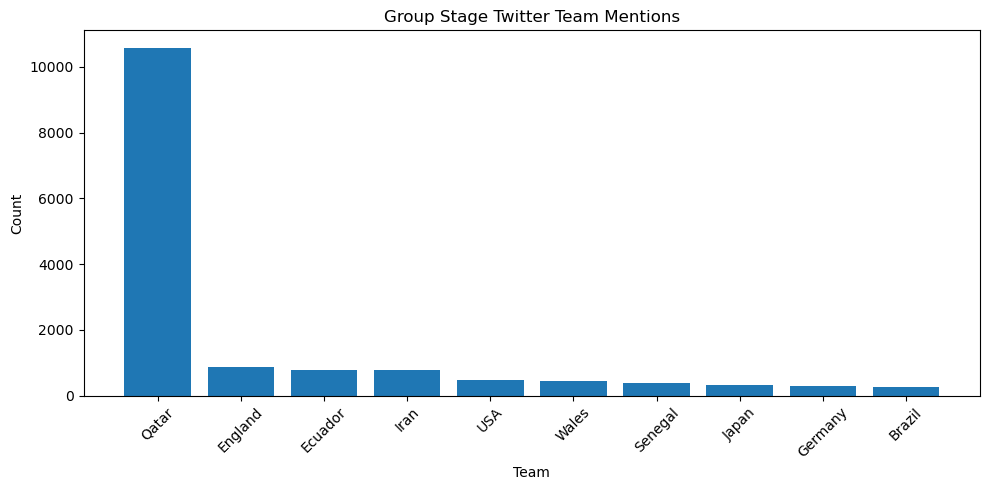

In [60]:
start_date = '2022-11-20'
end_date = '2022-12-2'

filtered_tournament = tournament[(tournament['Date'] >= start_date) & (tournament['Date'] <= end_date)]

team_counts = {team: 0 for team in unique_teams}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in unique_teams:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[:10]
top_10_counts = list(sorted_team_counts.values())[:10]

plt.figure(figsize=(10, 5))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Group Stage Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_7451/2918462821.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tournament['content'] = filtered_tournament['content'].str.lower()


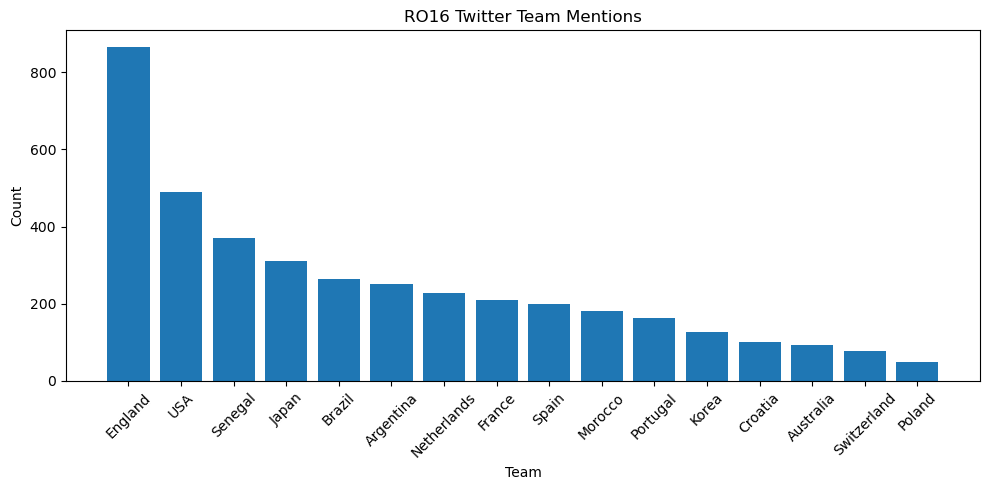

In [61]:
start_date = '2022-12-3'
end_date = '2022-12-7'

teams_of_interest = ['Netherlands', 'USA', 'Argentina', 'Australia', 'Japan', 'Croatia', 
                    'Brazil', 'Korea', 'England', 'Senegal', 'France', 'Poland', 'Morocco',
                    'Spain', 'Portugal', 'Switzerland']

team_counts = {team: 0 for team in teams_of_interest}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in teams_of_interest:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

RO16_teams = list(sorted_team_counts.keys())[:len(teams_of_interest)]
RO16_counts = list(sorted_team_counts.values())[:len(teams_of_interest)]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(RO16_teams, RO16_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('RO16 Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_7451/4235212796.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tournament['content'] = filtered_tournament['content'].str.lower()


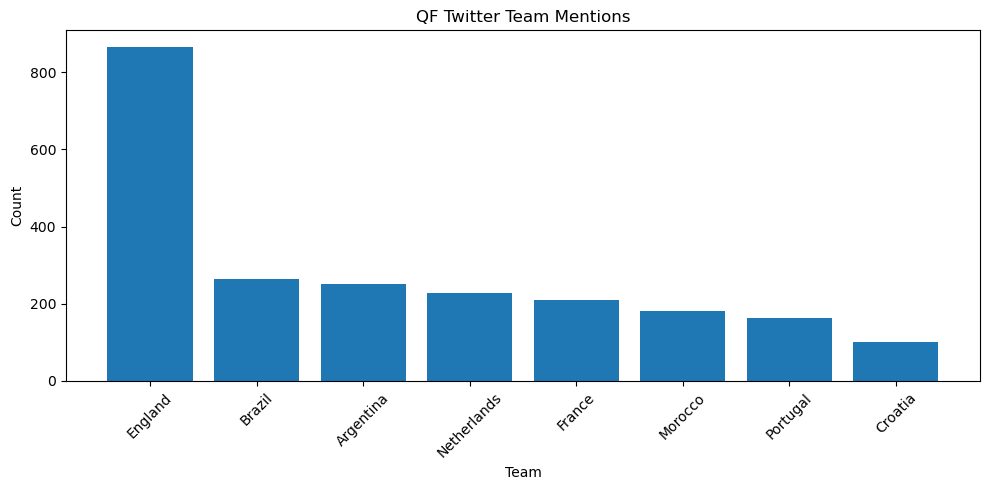

In [62]:
start_date = '2022-12-9'
end_date = '2022-12-11'

teams_of_interest = ['Netherlands', 'Argentina', 'Croatia', 'Brazil', 'England', 'France', 'Morocco', 'Portugal']

team_counts = {team: 0 for team in teams_of_interest}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in teams_of_interest:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

QF_teams = list(sorted_team_counts.keys())[:len(teams_of_interest)]
QF_counts = list(sorted_team_counts.values())[:len(teams_of_interest)]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(QF_teams, QF_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('QF Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_7451/634407326.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tournament['content'] = filtered_tournament['content'].str.lower()


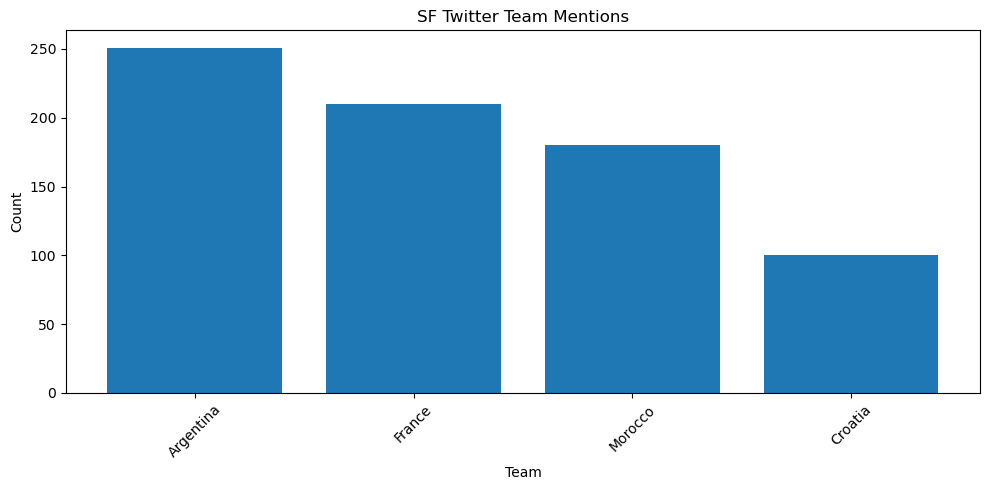

In [63]:
start_date = '2022-12-13'
end_date = '2022-12-15'

teams_of_interest = ['Argentina', 'Croatia', 'France', 'Morocco']

team_counts = {team: 0 for team in teams_of_interest}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in teams_of_interest:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

SF_teams = list(sorted_team_counts.keys())[:len(teams_of_interest)]
SF_counts = list(sorted_team_counts.values())[:len(teams_of_interest)]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(SF_teams, SF_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('SF Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Post-Tournament

In [64]:
team_counts = {team: 0 for team in unique_teams}

for team in unique_teams:
    team_counts[team] = post_tournament['content'].str.count(team.lower()).sum()

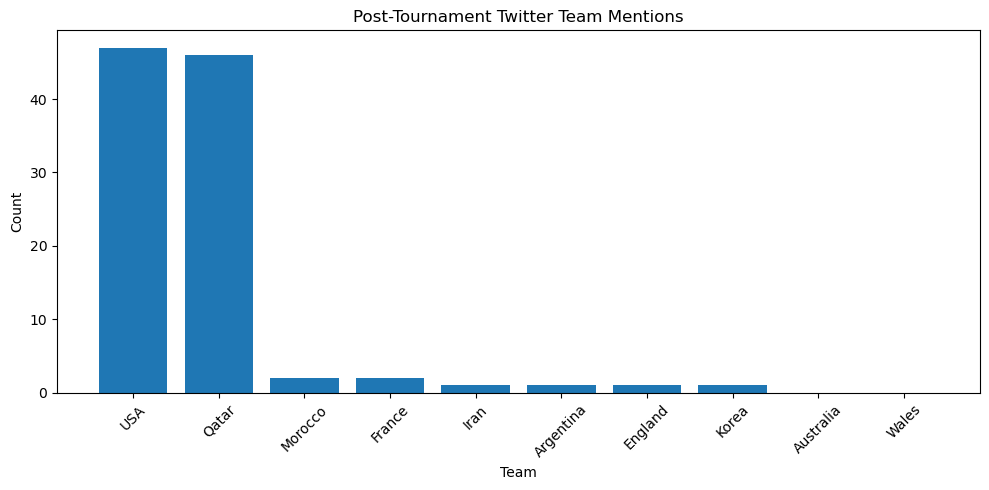

In [65]:
sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[:10]
top_10_counts = list(sorted_team_counts.values())[:10]

plt.figure(figsize=(10, 5))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Post-Tournament Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Sentiment Analysis

In [66]:
nltk.download('movie_reviews')
nltk.download('vader_lexicon')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/farrelw/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/farrelw/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [67]:
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

twitter['Sentiment_Score'] = twitter['content'].apply(get_sentiment)

In [68]:
num_samples = 1000
sample_size = 1000

results = []

for iteration in range(num_samples):
    sample = twitter.sample(n=sample_size, random_state=iteration)
    
    ex_pos_likes = sample[sample['Sentiment_Score'] > 0.5]['Likes'].mean()
    pos_likes = sample[(sample['Sentiment_Score'] >= 0.05) & (sample['Sentiment_Score'] <= 0.5)]['Likes'].mean()
    neu_likes = sample[(sample['Sentiment_Score'] >= -0.05) & (sample['Sentiment_Score'] <= 0.05)]['Likes'].mean()
    neg_likes = sample[(sample['Sentiment_Score'] <= -0.05) & (sample['Sentiment_Score'] >= -0.5)]['Likes'].mean()
    ex_neg_likes = sample[sample['Sentiment_Score'] < -0.5]['Likes'].mean()
    
    results.append({'Iteration': iteration + 1, 'Ex_Pos_Likes': ex_pos_likes, 'Pos_Likes': pos_likes, 'Neu_Likes': neu_likes, 'Neg_Likes': neg_likes, 'Ex_Neg_Likes': ex_neg_likes})

results_df = pd.concat([pd.DataFrame(result, index=[0]) for result in results], ignore_index=True)

results_df.mean()

Iteration       500.500000
Ex_Pos_Likes    122.169998
Pos_Likes       189.445585
Neu_Likes       191.816726
Neg_Likes       208.062931
Ex_Neg_Likes     80.616659
dtype: float64

In [69]:
average_sentiment_scores = {'Country': [], 'Average_Sentiment_Score': []}

for country in unique_teams:
    country_data = twitter[twitter['content'].str.contains(country, case=False)]
    
    average_sentiment_score = country_data['Sentiment_Score'].mean()
    
    average_sentiment_scores['Country'].append(country)
    average_sentiment_scores['Average_Sentiment_Score'].append(average_sentiment_score)

avg_sentiment = pd.DataFrame(average_sentiment_scores)

In [70]:
avg_sentiment = avg_sentiment.sort_values(by='Average_Sentiment_Score', ascending=False)
avg_sentiment = avg_sentiment.reset_index(drop=True)

avg_sentiment

,Country,Average_Sentiment_Score
0,Serbia,0.263844
1,Argentina,0.222051
2,Brazil,0.211948
3,Morocco,0.200603
4,Japan,0.178449
5,Costa,0.178437
6,Belgium,0.173650
7,Spain,0.167268
8,Portugal,0.166802
9,Saudi,0.158429


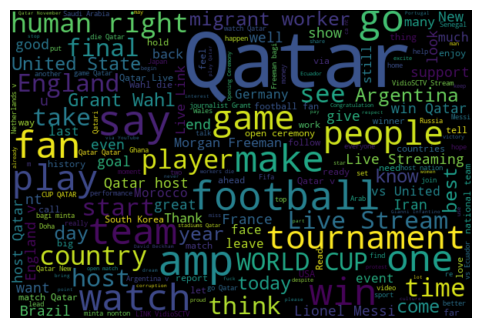

In [71]:
wordcloud = WordCloud(
    width=600,
    height=400,
    random_state=1,
)
data = twitter[twitter['Sentiment_Score'] < 0.5]
text_data = ' '.join(data)
wordcloud.generate(text_data)
wordcloud.to_image()

all_words_lem = ' '.join([word for word in twitter['content']])

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=1, 
                     max_font_size=100).generate(all_words_lem)
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

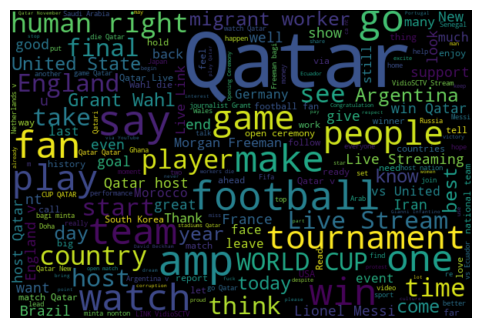

In [72]:
wordcloud = WordCloud(
    width=600,
    height=400,
    random_state=1,
)
data = twitter[twitter['Sentiment_Score'] > -0.5]
text_data = ' '.join(data)
wordcloud.generate(text_data)
wordcloud.to_image()

all_words_lem = ' '.join([word for word in twitter['content']])

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=1, 
                     max_font_size=100).generate(all_words_lem)
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [73]:
polarity = []
subjectivity = []

for text in twitter["content"]: 
    polarity.append(TextBlob(text).sentiment.polarity) 
    subjectivity.append(TextBlob(text).sentiment.subjectivity)
    
twitter['Polarity'] = polarity
twitter['Subjectivity'] = subjectivity

In [74]:
def assign_sentiment(polarity_score):
    if polarity_score > 0:
        return 'pos'
    elif polarity_score < 0:
        return 'neg'
    else:
        return 'neutral'

twitter['Sentiment'] = twitter['Polarity'].apply(assign_sentiment)

In [75]:
X = twitter['content']
y = twitter['Sentiment']

vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6150666917151982


In [76]:
X = twitter['content']
y = twitter['Sentiment']

vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9154612060867932


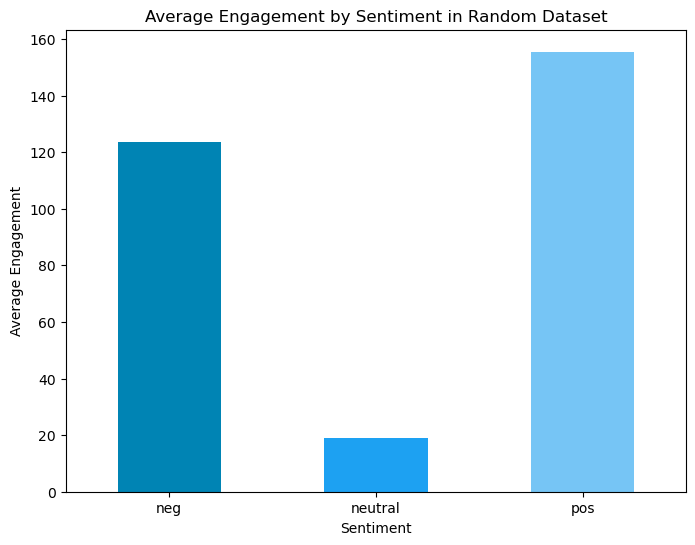

In [77]:
np.random.seed(0)
random_data = twitter.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), 300)))

X_random = random_data['content']
y_random = random_data['Sentiment']

X_vectorized_random = vectorizer.transform(X_random)
y_pred_random = svm_model.predict(X_vectorized_random)

data_random = pd.DataFrame({'Sentiment': y_pred_random, 'Engagement': random_data['Likes']})

average_engagement_random = data_random.groupby('Sentiment')['Engagement'].mean()

plt.figure(figsize=(8, 6))
average_engagement_random.plot(kind='bar', color=['#0084b4', '#1da1f2', '#76c5f5'])
plt.title("Average Engagement by Sentiment in Random Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Average Engagement")
plt.xticks(range(len(average_engagement_random.index)), average_engagement_random.index, rotation=0)
plt.show()

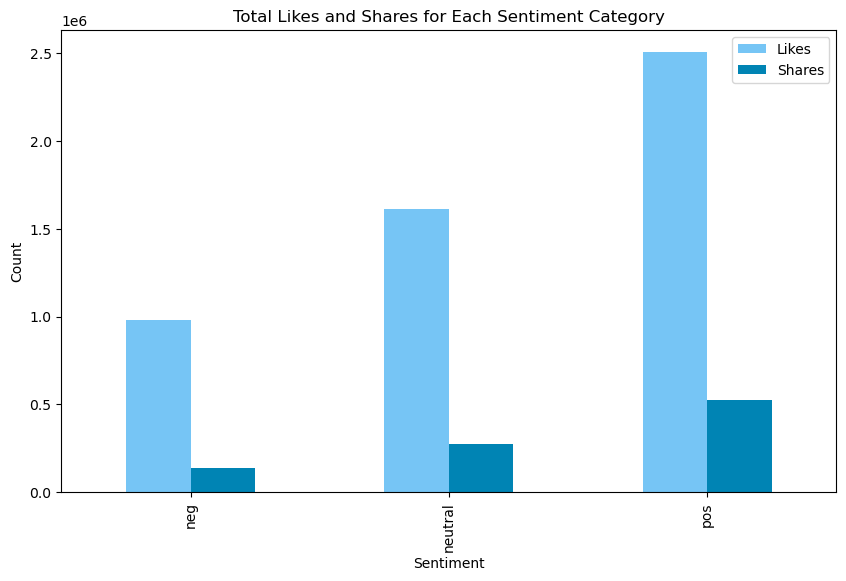

In [78]:
sum_likes_comments = twitter.groupby('Sentiment')[['Likes', 'Shares']].sum()

sum_likes_comments.plot(kind='bar', figsize=(10, 6), color=['#76c5f5', '#0084b4'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Total Likes and Shares for Each Sentiment Category')
plt.show()